In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# In R, this can be computed using scales::pal_hue()(4)
custom_palette = ['#F8766D', '#7CAE00', '#00BFC4', '#C77CFF']

In [2]:
operator_map = {
    "phecode": "Phecode",
    "and": "and(x, y)",
    "not": "and(x, not(y))",
    "or": "or(x, y)",
}
operator_order = list(operator_map.values())
print(operator_order)

['Phecode', 'and(x, y)', 'and(x, not(y))', 'or(x, y)']


<Figure size 800x800 with 0 Axes>

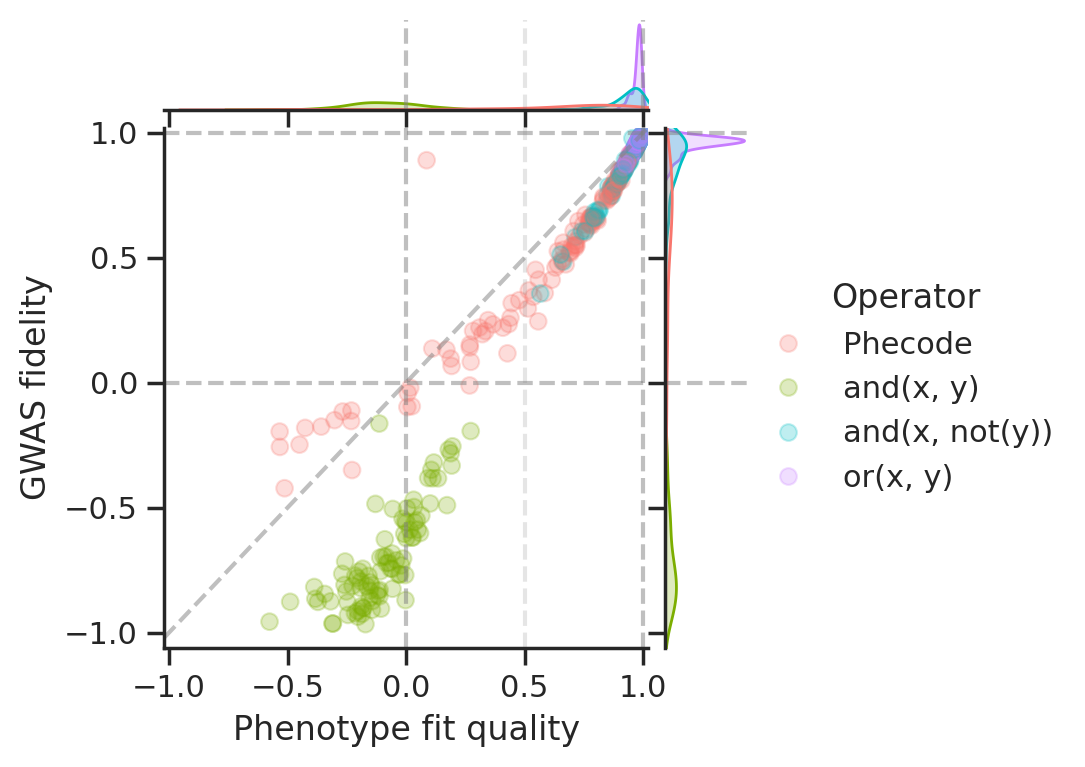

In [3]:
plot_df = (
    pl.scan_parquet("data/pheno_summary/direct_vs_indirect_anon.parquet")
    .join(pl.scan_parquet("data/gwas_summary/direct_vs_indirect_anon.parquet"), on=["kind", "phenotype", "k"], suffix="_gwas")
    .rename({"rsq": "rsq_pheno"})
    .with_columns(
        (
            pl.col("phenotype")
            .str.extract("^(and|or|not)")
            .fill_null("phecode")
            .replace({
                "phecode": "Phecode",
                "and": "and(x, y)",
                "not": "and(x, not(y))",
                "or": "or(x, y)",
            })
            .alias("operator")
        ),
        pl.col("k").cast(pl.Int32).cast(pl.String),
    )
    .collect()
)

sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(custom_palette)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(4, 4))

(
    plot_df
    .filter(
        pl.col("rsq_pheno").ge(-0.97),
        pl.col("rsq_gwas").ge(-0.97),
        pl.col("k").eq("10")
    )
    .pipe(
        sns.jointplot, x="rsq_pheno", y="rsq_gwas", hue="operator", alpha=0.25, 
        xlim=(-1.02, 1.02), ylim=(-1.06, 1.02), hue_order=operator_order, 
        height=4, edgecolors="face", linewidths=0.75, marginal_kws={'common_norm':False}
    )
    .refline(x=0, y=0, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=1, y=1, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=0.5, linestyle="dashed", color="gray", alpha=0.2)
)
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
lgd = plt.legend(
    bbox_to_anchor=(1.17, 0.5), loc="center left", title="Operator", frameon=False
)
plt.savefig(
    "img/overall-performance-marginal.png", dpi=400, 
    format="png", bbox_extra_artists=(lgd,), bbox_inches='tight'
)

<Figure size 800x800 with 0 Axes>

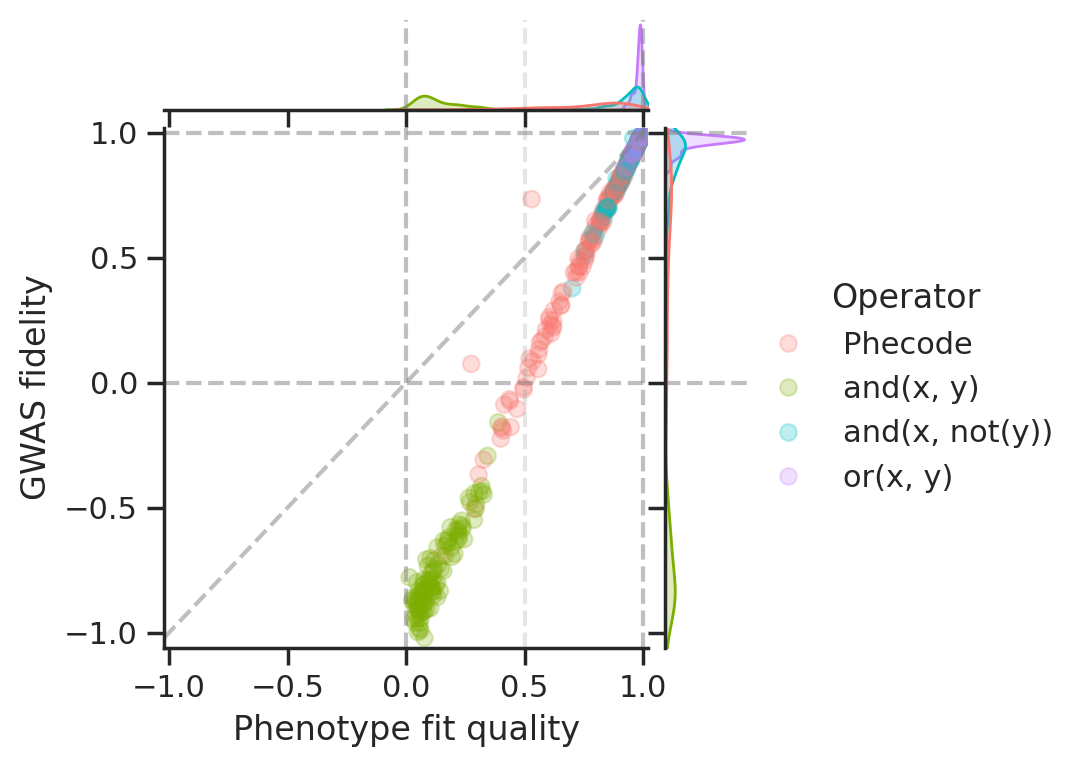

In [4]:
plot_df = (
    pl.scan_parquet("data/pheno_summary/direct_vs_indirect_non_anon.parquet")
    .join(pl.scan_parquet("data/gwas_summary/direct_vs_indirect_non_anon.parquet"), on=["kind", "phenotype"], suffix="_gwas")
    .rename({"rsq": "rsq_pheno"})
    .with_columns(
        pl.col("phenotype")
        .str.extract("^(and|or|not)")
        .fill_null("phecode")
        .replace({
            "phecode": "Phecode",
            "and": "and(x, y)",
            "not": "and(x, not(y))",
            "or": "or(x, y)",
        })
        .alias("operator")
    )
    .collect()
)

sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(custom_palette)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(4, 4))

(
    plot_df
    .pipe(
        sns.jointplot, x="rsq_pheno", y="rsq_gwas", hue="operator", alpha=0.25, 
        xlim=(-1.02, 1.02), ylim=(-1.06, 1.02), hue_order=operator_order, 
        height=4, edgecolors="face", linewidths=0.75, marginal_kws={'common_norm':False}
    )
    .refline(x=0, y=0, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=1, y=1, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=0.5, linestyle="dashed", color="gray", alpha=0.2)
    
)
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
lgd = plt.legend(
    bbox_to_anchor=(1.17, 0.5), loc="center left", title="Operator", frameon=False
)
plt.savefig(
    "img/linearization-performance-marginal.png", dpi=400, 
    format="png", bbox_extra_artists=(lgd,), bbox_inches='tight'
)